In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
dataset = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

# Read the dataset into a Pandas DataFrame
TITANIC = pd.read_csv(dataset)

In [3]:
import sys
sys.path.append('..')
from nampy.models.NATT import NATT

In [4]:
model = NATT(
    "survived ~  -1 + MLP(fare) +  MLP(age) + Transformer(sex):Transformer(deck)", 
    data=TITANIC, 
    feature_dropout=0.0001,
    binning_task="regression"
    )

--- Preprocessing ---


5it [00:00,  7.75it/s]
4it [00:00, 775.39it/s]


In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy()},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), tf.keras.metrics.AUC(name="auc")]},
    )

history = model.fit(
    model.training_dataset, 
    epochs=20, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/20
------------- Network architecture --------------
Transformer -> (ListWrapper(['sex_.', 'deck_.']), dims=32, depth=4, heads=8) -> MLP(input_dim=64) -> output dimension=1
fare -> MLP(feature=fare, n_params=12736) -> output dimension=1
age -> MLP(feature=age, n_params=12736) -> output dimension=1
1/1 [==============================] - 9s 9s/step - loss: 3.1408 - output_loss: 3.1408 - output_PR AUC: 0.4027 - output_auc: 0.4984 - val_loss: 1.1237 - val_output_loss: 1.1237 - val_output_PR AUC: 0.4501 - val_output_auc: 0.5702
Epoch 2/20
1/1 [==============================] - 0s 117ms/step - loss: 2.5652 - output_loss: 2.5652 - output_PR AUC: 0.4310 - output_auc: 0.5170 - val_loss: 0.8384 - val_output_loss: 0.8384 - val_output_PR AUC: 0.4640 - val_output_auc: 0.6197
Epoch 3/20
1/1 [==============================] - 0s 148ms/step - loss: 1.9363 - output_loss: 1.9363 - output_PR AUC: 0.3819 - output_auc: 0.4832 - val_loss: 0.6683 - val_output_loss: 0.6683 - val_output_PR AUC: 0.4649 

fare
age


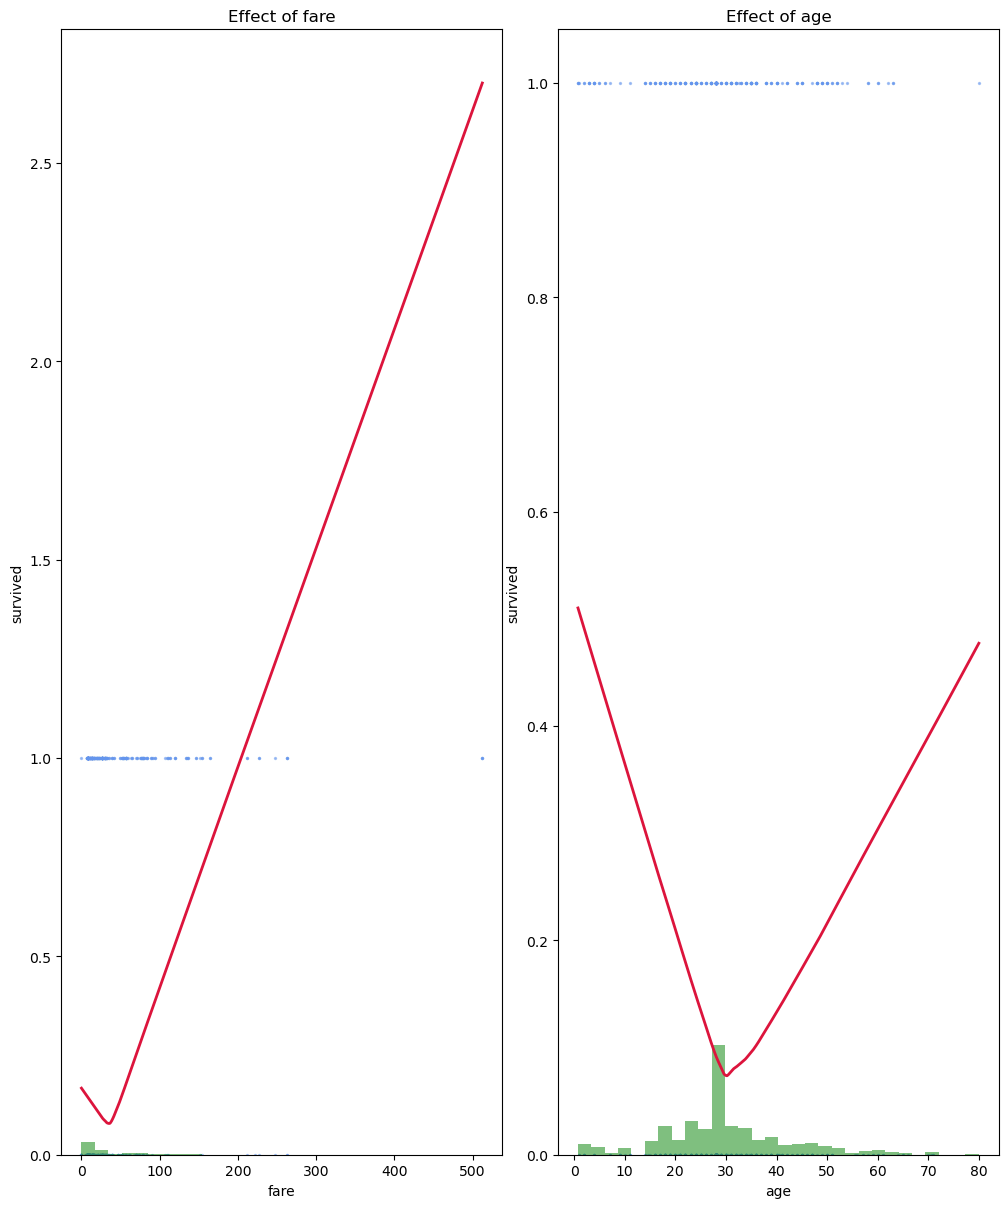

In [6]:
model.plot()

--- Preprocessing ---


5it [00:00, 10.57it/s]


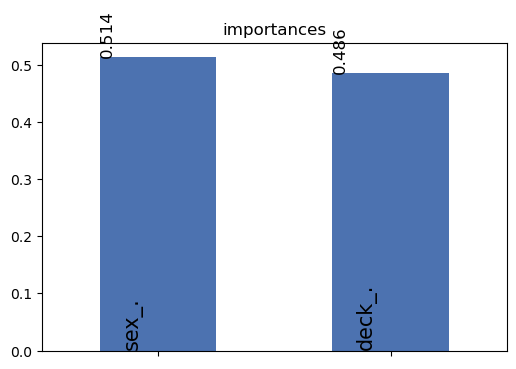

In [7]:
model.plot_importances()

In [8]:
model.plot_all_effects(port=8051)

In [9]:
model.plot_single_effects(port=8052)

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00, 10.53it/s]


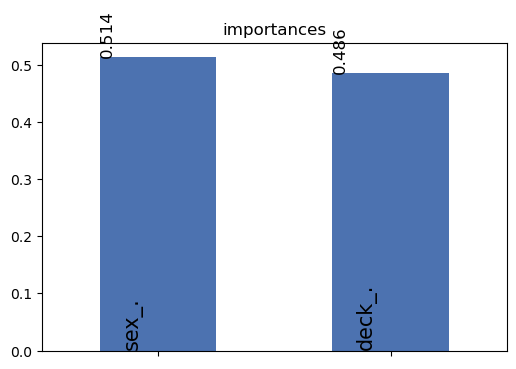

In [10]:
model.plot_importances()

--- Preprocessing ---


5it [00:00,  9.38it/s]


<Figure size 1200x400 with 0 Axes>

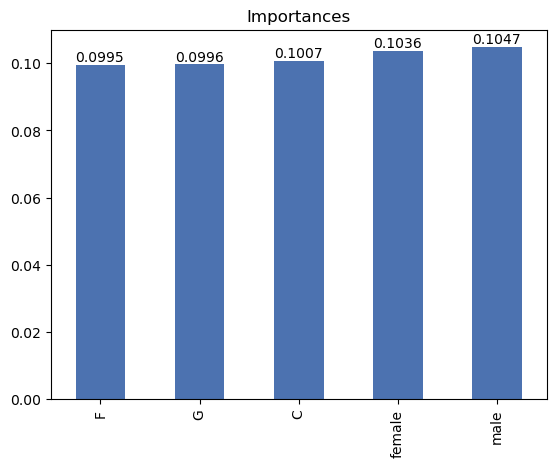

In [11]:
model.plot_categorical_importances()

# test continuous feature interactions

In [4]:
model = NATT(
    "survived ~  -1 + MLP(fare):MLP(age) + Transformer(sex):Transformer(deck):Transformer(embark_town)",
    data=TITANIC, 
    feature_dropout=0.0001)

--- Preprocessing ---


6it [00:00,  8.77it/s]
5it [00:00, 1149.12it/s]


In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), "accuracy"], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=30, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/30
------------- Network architecture --------------
Transformer -> (ListWrapper(['sex_.', 'deck_.', 'embark_town_.']), dims=32, depth=4, heads=8) -> MLP(input_dim=96) -> output dimension=1
fare_._age -> MLP(feature=fare_._age, n_params=12864) -> output dimension=1
1/1 [==============================] - 9s 9s/step - loss: 3.2557 - output_loss: 3.2557 - output_PR AUC: 0.3893 - output_accuracy: 0.6096 - val_loss: 1.3452 - val_output_loss: 1.3452 - val_output_PR AUC: 0.5044 - val_output_accuracy: 0.5760
Epoch 2/30
1/1 [==============================] - 0s 159ms/step - loss: 2.7995 - output_loss: 2.7995 - output_PR AUC: 0.4200 - output_accuracy: 0.6295 - val_loss: 1.1114 - val_output_loss: 1.1114 - val_output_PR AUC: 0.5779 - val_output_accuracy: 0.5840
Epoch 3/30
1/1 [==============================] - 0s 126ms/step - loss: 2.3231 - output_loss: 2.3231 - output_PR AUC: 0.4234 - output_accuracy: 0.6195 - val_loss: 0.9886 - val_output_loss: 0.9886 - val_output_PR AUC: 0.3412 - val_ou